# MSCS 634 Lab 1: Data Analysis and Visualization
**Student:** Sai Venkata Bharath Reddy Singareddy
**Course:** MSCS 634 - Data Analysis  
**Date:** 1/2/2026  
**Dataset:** Diamonds Dataset (Seaborn)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

df = sns.load_dataset('diamonds')

print(f"Dataset Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

print("\nFirst 5 rows:")
df.head()

Dataset Shape: (53940, 10)
Columns: ['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price', 'x', 'y', 'z']

First 5 rows:


,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


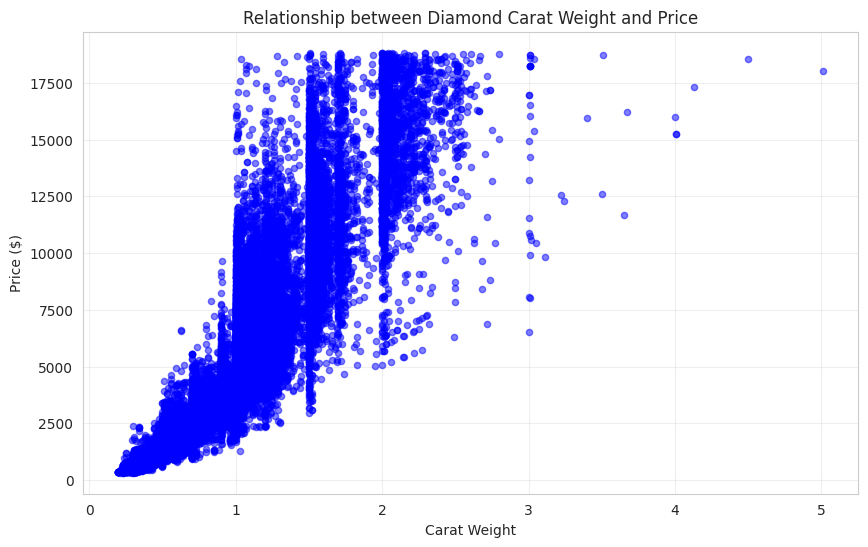

In [2]:
plt.figure(figsize=(10, 6))
plt.scatter(df['carat'], df['price'], alpha=0.5, c='blue', s=20)
plt.xlabel('Carat Weight')
plt.ylabel('Price ($)')
plt.title('Relationship between Diamond Carat Weight and Price')
plt.grid(True, alpha=0.3)
plt.show()

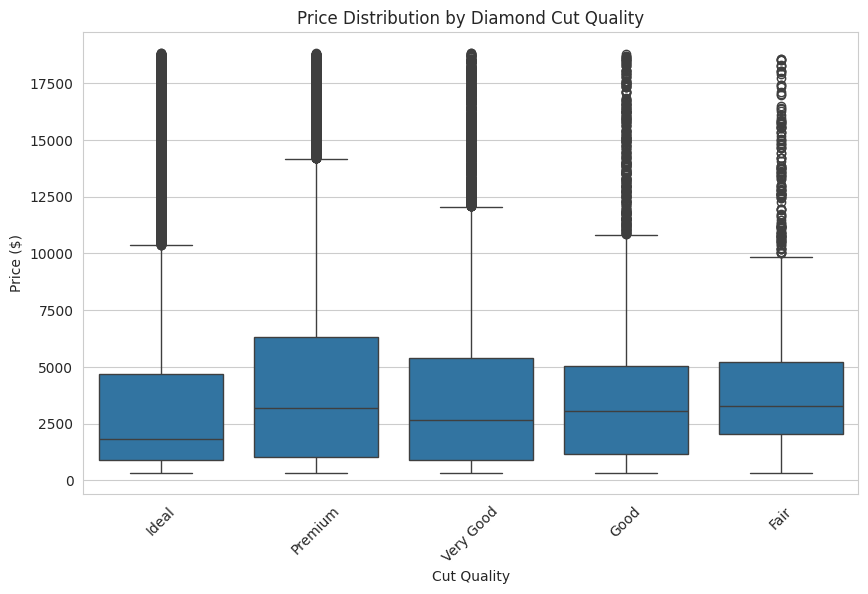

In [3]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='cut', y='price', data=df)
plt.title('Price Distribution by Diamond Cut Quality')
plt.xlabel('Cut Quality')
plt.ylabel('Price ($)')
plt.xticks(rotation=45)
plt.show()

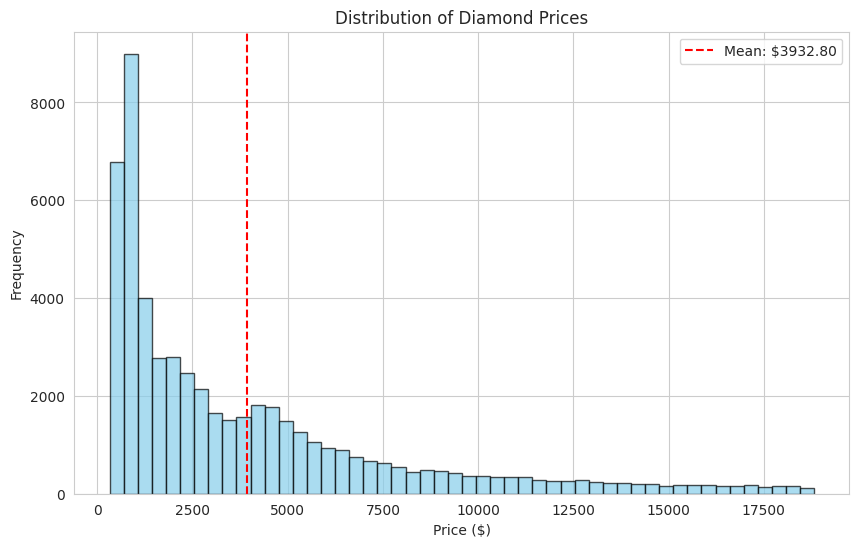

In [4]:
plt.figure(figsize=(10, 6))
plt.hist(df['price'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Price ($)')
plt.ylabel('Frequency')
plt.title('Distribution of Diamond Prices')
plt.axvline(df['price'].mean(), color='red', linestyle='--', label=f'Mean: ${df["price"].mean():.2f}')
plt.legend()
plt.show()

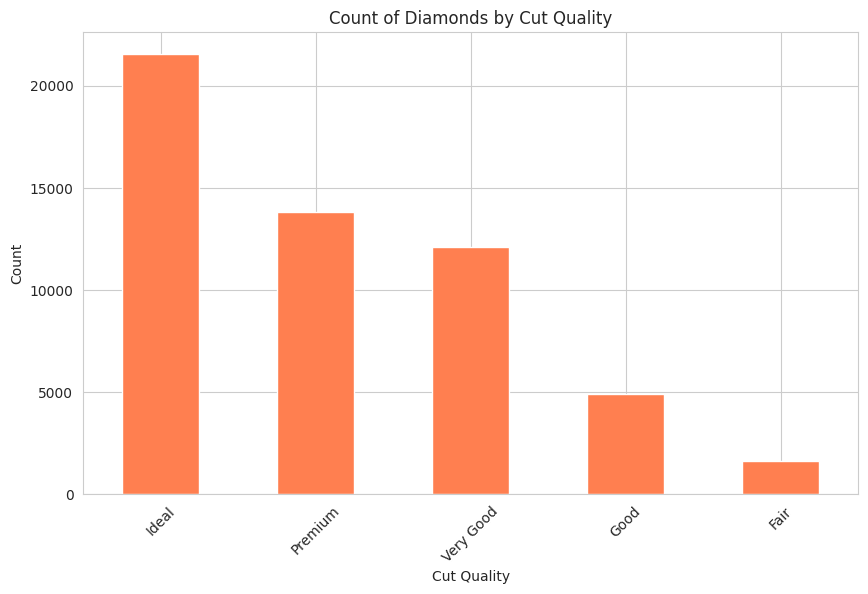

In [5]:
cut_counts = df['cut'].value_counts()
plt.figure(figsize=(10, 6))
cut_counts.plot(kind='bar', color='coral')
plt.title('Count of Diamonds by Cut Quality')
plt.xlabel('Cut Quality')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

3.1 Handling Missing Values

In [29]:
print("BEFORE - Missing Values Check:")
print(df.isnull().sum())

# Check for missing values or zeros that represent missing data
# In diamonds dataset, x, y, z dimensions of 0 are actually missing
print(f"Zero dimensions (invalid data): {(df[['x', 'y', 'z']] == 0).sum()}")

# Handle by removing rows with zero dimensions
df_clean = df[(df['x'] > 0) & (df['y'] > 0) & (df['z'] > 0)].copy()
print("="*50)
print(f"AFTER - Shape changed from {df.shape} to {df_clean.shape}")
print("Missing/Invalid values handled by removing rows with zero dimensions")

BEFORE - Missing Values Check:
carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64
Zero dimensions (invalid data): x     8
y     7
z    20
dtype: int64
AFTER - Shape changed from (53940, 10) to (53920, 10)
Missing/Invalid values handled by removing rows with zero dimensions


3.2 Outlier Detection and Removal (IQR Method)

In [21]:

Q1 = df_clean['price'].quantile(0.25)
Q3 = df_clean['price'].quantile(0.75)
IQR = Q3 - Q1

print(f"Q1 (25th percentile): ${Q1:.2f}")
print(f"Q3 (75th percentile): ${Q3:.2f}")
print(f"IQR: ${IQR:.2f}")
print(f"Lower bound: ${Q1 - 1.5*IQR:.2f}")
print(f"Upper bound: ${Q3 + 1.5*IQR:.2f}")

# Identify outliers
outliers = df_clean[(df_clean['price'] < (Q1 - 1.5*IQR)) |
                    (df_clean['price'] > (Q3 + 1.5*IQR))]
print(f"Number of outliers detected: {len(outliers)}")

# Remove outliers
df_no_outliers = df_clean[(df_clean['price'] >= (Q1 - 1.5*IQR)) &
                          (df_clean['price'] <= (Q3 + 1.5*IQR))].copy()

print(f"Dataset shape after outlier removal: {df_no_outliers.shape}")


Q1 (25th percentile): $949.00
Q3 (75th percentile): $5323.25
IQR: $4374.25
Lower bound: $-5612.38
Upper bound: $11884.62
Number of outliers detected: 3532
Dataset shape after outlier removal: (50388, 10)


3.3 Data Reduction

In [28]:
print("BEFORE Reduction:")
print(f"Shape: {df_no_outliers.shape}")
print(f"Columns: {df_no_outliers.columns.tolist()}")

# Technique 1: Drop less relevant columns (x, y, z are dimensions, keep carat instead)
df_reduced = df_no_outliers.drop(['x', 'y', 'z'], axis=1)

# Technique 2: Random sampling (reduce to 30% of data for faster processing)
df_sampled = df_reduced.sample(frac=0.3, random_state=42)
print("="*50)
print(f"AFTER Reduction:")
print(f"Shape: {df_sampled.shape}")
print(f"Columns: {df_sampled.columns.tolist()}")
print("Reduced by: removing dimension columns (x,y,z) and sampling 30% of rows")


BEFORE Reduction:
Shape: (50388, 10)
Columns: ['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price', 'x', 'y', 'z']
AFTER Reduction:
Shape: (15116, 7)
Columns: ['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price']
Reduced by: removing dimension columns (x,y,z) and sampling 30% of rows


3.4 Data Scaling and Discretization

In [27]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

print("BEFORE Scaling (first 5 rows of numeric data):")
numeric_cols = ['carat', 'depth', 'table', 'price']
print(df_sampled[numeric_cols].head())

scaler = MinMaxScaler()
df_scaled = df_sampled.copy()
df_scaled[numeric_cols] = scaler.fit_transform(df_sampled[numeric_cols])
print("="*50)
print(f"AFTER Min-Max Scaling (0-1 range):")
print(df_scaled[numeric_cols].head())

# Discretization: Convert price into categories
# First get original price back for binning (or use unscaled data)
price_bins = [0, 1000, 5000, 10000, float('inf')]
price_labels = ['Budget', 'Mid-Range', 'Premium', 'Luxury']
df_scaled['price_category'] = pd.cut(df_sampled['price'],
                                     bins=price_bins,
                                     labels=price_labels)

print(f"Price Categories Distribution:")
print(df_scaled['price_category'].value_counts())


BEFORE Scaling (first 5 rows of numeric data):
       carat  depth  table  price
7172    0.92   63.7   57.0   4183
7835    1.01   61.5   57.0   4299
46177   0.60   62.1   57.0   1746
36953   0.27   61.6   55.0    480
6377    0.25   60.7   60.0    576
AFTER Min-Max Scaling (0-1 range):
          carat     depth     table     price
7172   0.247423  0.429104  0.333333  0.333737
7835   0.278351  0.347015  0.333333  0.343774
46177  0.137457  0.369403  0.333333  0.122869
36953  0.024055  0.350746  0.250000  0.013325
6377   0.017182  0.317164  0.458333  0.021632
Price Categories Distribution:
price_category
Mid-Range    7453
Budget       4363
Premium      2833
Luxury        467
Name: count, dtype: int64


Step 4: Statistical Analysis



4.1 General Overview

In [25]:
print("Dataset Info:")
df_sampled.info()

print("="*50)
print("Statistical Summary:")
df_sampled.describe()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 15116 entries, 7172 to 38763
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   carat    15116 non-null  float64 
 1   cut      15116 non-null  category
 2   color    15116 non-null  category
 3   clarity  15116 non-null  category
 4   depth    15116 non-null  float64 
 5   table    15116 non-null  float64 
 6   price    15116 non-null  int64   
dtypes: category(3), float64(3), int64(1)
memory usage: 635.7 KB
Statistical Summary:


,carat,depth,table,price
count,15116.000000,15116.000000,15116.000000,15116.000000
mean,0.722359,61.761736,57.440368,3145.283541
std,0.379691,1.444661,2.244577,2733.321143
min,0.200000,52.200000,49.000000,326.000000
25%,0.380000,61.100000,56.000000,907.000000
50%,0.700000,61.800000,57.000000,2192.000000
75%,1.010000,62.500000,59.000000,4622.500000
max,3.110000,79.000000,73.000000,11883.000000


4.2 Central Tendency Measures

In [24]:
print("CENTRAL TENDENCY MEASURES")
print("="*50)

numeric_columns = ['carat', 'depth', 'table', 'price']

for col in numeric_columns:
    print(f"{col.upper()}:")
    print(f"  Minimum: {df_sampled[col].min():.4f}")
    print(f"  Maximum: {df_sampled[col].max():.4f}")
    print(f"  Mean: {df_sampled[col].mean():.4f}")
    print(f"  Median: {df_sampled[col].median():.4f}")
    print(f"  Mode: {df_sampled[col].mode()[0]:.4f}")

CENTRAL TENDENCY MEASURES
CARAT:
  Minimum: 0.2000
  Maximum: 3.1100
  Mean: 0.7224
  Median: 0.7000
  Mode: 0.3000
DEPTH:
  Minimum: 52.2000
  Maximum: 79.0000
  Mean: 61.7617
  Median: 61.8000
  Mode: 61.9000
TABLE:
  Minimum: 49.0000
  Maximum: 73.0000
  Mean: 57.4404
  Median: 57.0000
  Mode: 56.0000
PRICE:
  Minimum: 326.0000
  Maximum: 11883.0000
  Mean: 3145.2835
  Median: 2192.0000
  Mode: 625.0000


4.3 Dispersion Measures

In [23]:
print("DISPERSION MEASURES")
print("="*50)

for col in numeric_columns:
    data = df_sampled[col]
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)

    print(f"{col.upper()}:")
    print(f"  Range: {data.max() - data.min():.4f}")
    print(f"  Q1 (25%): {Q1:.4f}")
    print(f"  Q3 (75%): {Q3:.4f}")
    print(f"  IQR: {Q3 - Q1:.4f}")
    print(f"  Variance: {data.var():.4f}")
    print(f"  Std Dev: {data.std():.4f}")



DISPERSION MEASURES
CARAT:
  Range: 2.9100
  Q1 (25%): 0.3800
  Q3 (75%): 1.0100
  IQR: 0.6300
  Variance: 0.1442
  Std Dev: 0.3797
DEPTH:
  Range: 26.8000
  Q1 (25%): 61.1000
  Q3 (75%): 62.5000
  IQR: 1.4000
  Variance: 2.0870
  Std Dev: 1.4447
TABLE:
  Range: 24.0000
  Q1 (25%): 56.0000
  Q3 (75%): 59.0000
  IQR: 3.0000
  Variance: 5.0381
  Std Dev: 2.2446
PRICE:
  Range: 11557.0000
  Q1 (25%): 907.0000
  Q3 (75%): 4622.5000
  IQR: 3715.5000
  Variance: 7471044.4722
  Std Dev: 2733.3211


4.4 Correlation Analysis

CORRELATION MATRIX:
          carat     depth     table     price
carat  1.000000  0.043860  0.179550  0.914851
depth  0.043860  1.000000 -0.288614 -0.004983
table  0.179550 -0.288614  1.000000  0.120336
price  0.914851 -0.004983  0.120336  1.000000


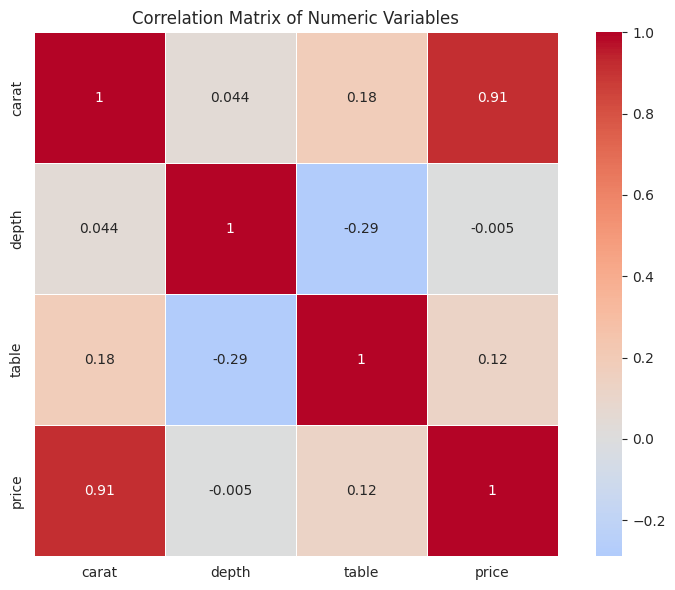

In [16]:
# Calculate correlation matrix
corr_matrix = df_sampled[numeric_columns].corr()

print("CORRELATION MATRIX:")
print(corr_matrix)

# Visualize correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5)
plt.title('Correlation Matrix of Numeric Variables')
plt.tight_layout()
plt.show()
